Theoretical Transformation Strain Calculator

- Calculated transformation strains for all 12 possible martensite variants along various tension deformation directions. Ref: http://dx.doi.org/10.1016/j.actamat.2015.03.022





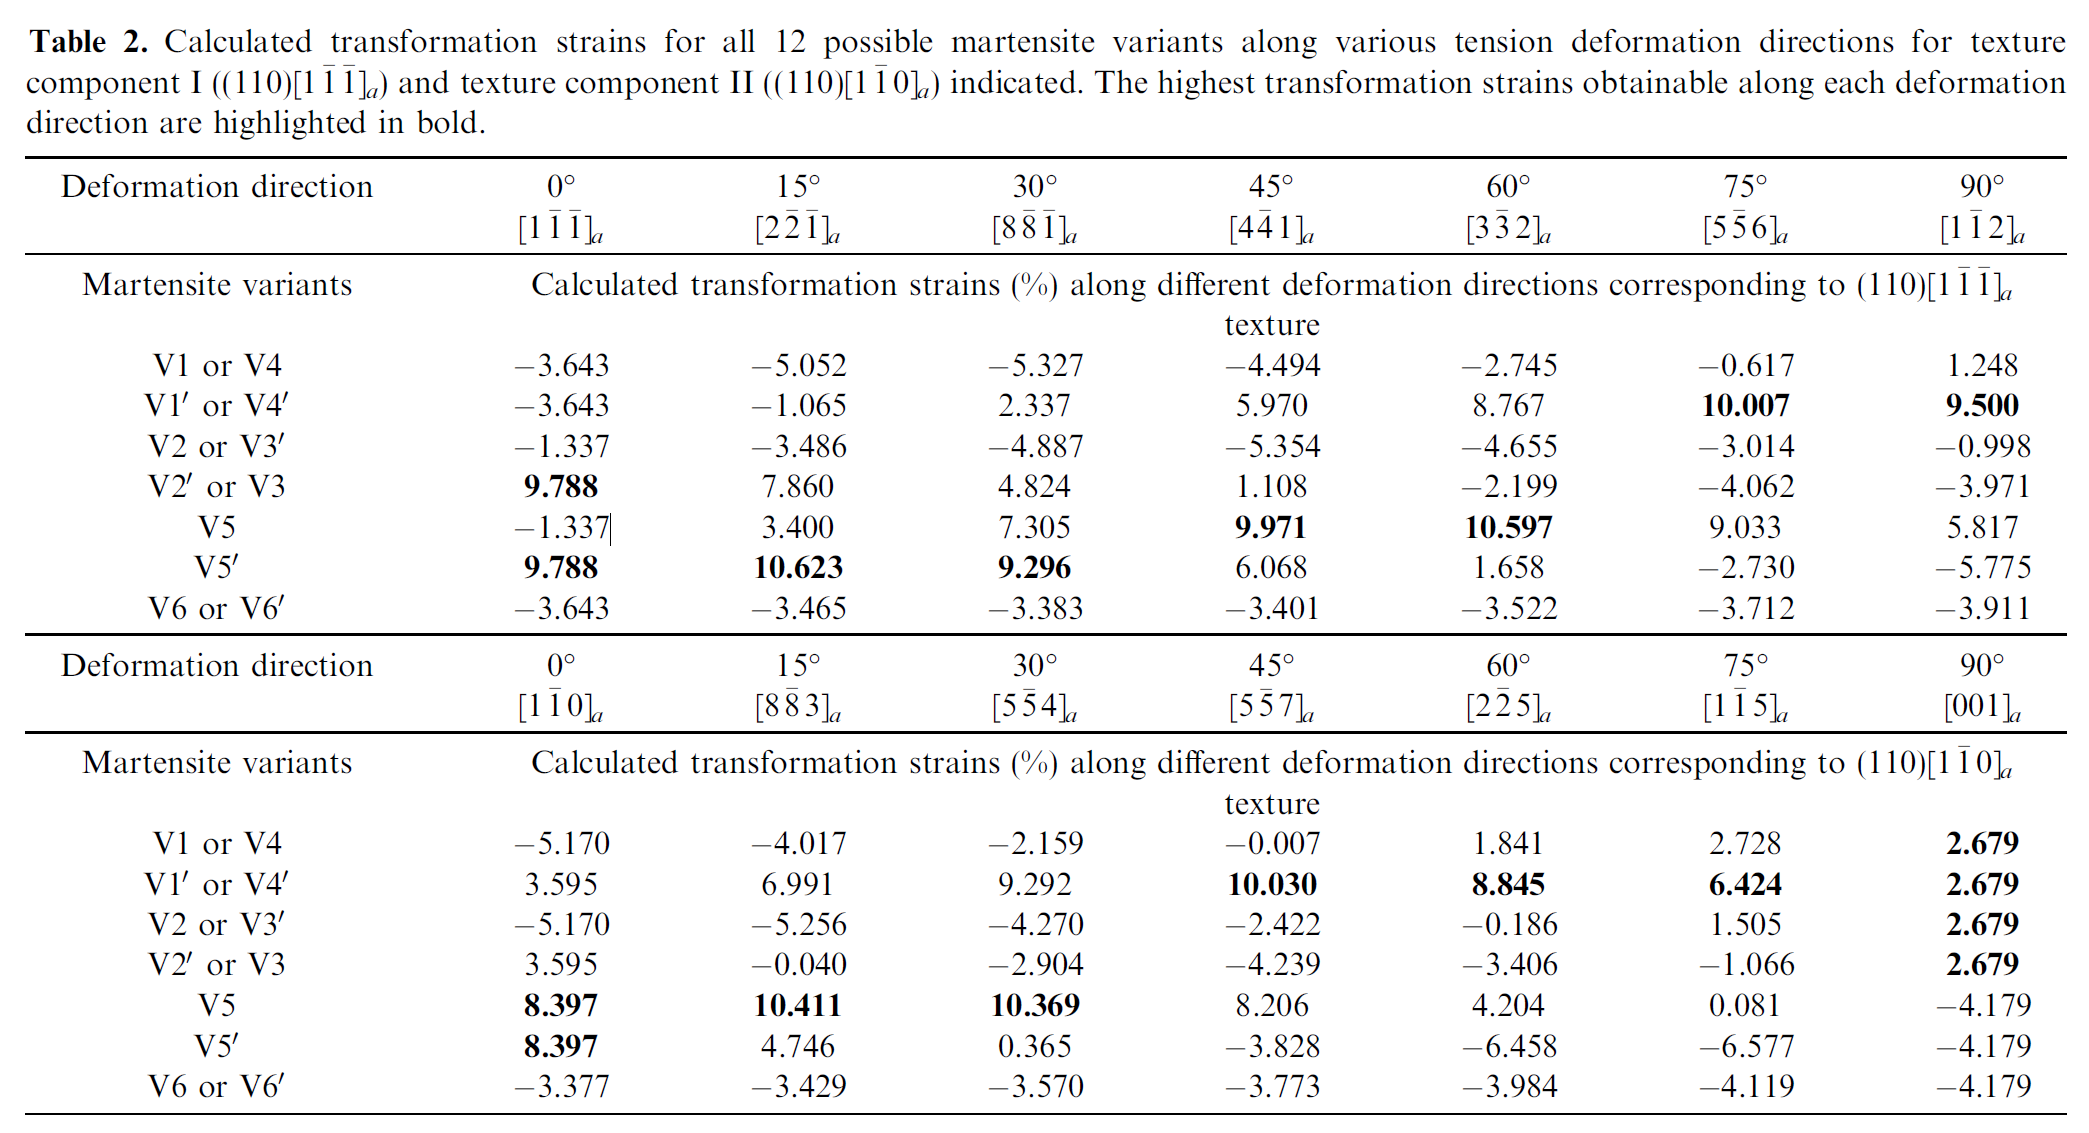

Imports

In [1]:
import numpy as np
from helper import TransformationStrainCalculator

Calculator

In [2]:
# Usage:
a0_val = 0.3015
a_val = 0.2889
b_val = 0.4120
c_val = 0.4662
beta_val = 96.8  # In degrees

texture_direction = [1, -1, -1]

deformation_directions = [
    np.array([1, -1, -1]),
    np.array([2, -2, -1]),
    np.array([8, -8, -1]),
    np.array([4, -4, 1]),
    np.array([3, -3, 2]),
    np.array([5, -5, 6]),
    np.array([1, -1, 2]),
]

calculator = TransformationStrainCalculator(a0_val, a_val, b_val, c_val, beta_val, texture_direction, deformation_directions)
calculator.print_results()


Texture direction: [ 1 -1 -1], Deformation direction: [ 1 -1 -1]
Angle between texture direction and deformation direction: 0.00 degrees
V1: -3.64149%
V1': -3.64149%
V2: -0.69835%
V2': 10.45327% <- Highest!
V3: 10.45327% <- Highest!
V3': -0.69835%
V4: -3.64149%
V4': -3.64149%
V5: -0.69835%
V5': 10.45327% <- Highest!
V6: -3.64149%
V6': -3.64149%

Texture direction: [ 1 -1 -1], Deformation direction: [ 2 -2 -1]
Angle between texture direction and deformation direction: 15.79 degrees
V1: -5.00872%
V1': -0.98967%
V2: -3.00905%
V2': 8.38059%
V3: 8.38059%
V3': -3.00905%
V4: -5.00872%
V4': -0.98967%
V5: 4.24447%
V5': 11.47338% <- Highest!
V6: -3.46295%
V6': -3.46295%

Texture direction: [ 1 -1 -1], Deformation direction: [ 8 -8 -1]
Angle between texture direction and deformation direction: 30.21 degrees
V1: -5.15591%
V1': 2.55994%
V2: -4.59278%
V2': 5.17063%
V3: 5.17063%
V3': -4.59278%
V4: -5.15591%
V4': 2.55994%
V5: 8.23884%
V5': 10.23080% <- Highest!
V6: -3.38002%
V6': -3.38002%

Texture d

In [3]:
# Usage:
a0_val = 0.3015
a_val = 0.2889
b_val = 0.4120
c_val = 0.4662
beta_val = 96.8  # In degrees

texture_direction = [1, -1, 0]

deformation_directions = [
    np.array([1, -1, 0]),
    np.array([8, -8, 3]),
    np.array([5, -5, 4]),
    np.array([5, -5, 7]),
    np.array([2, -2, 5]),
    np.array([1, -1, 5]),
    np.array([0, 0, 1]),
]

calculator = TransformationStrainCalculator(a0_val, a_val, b_val, c_val, beta_val, texture_direction, deformation_directions)
calculator.print_results()


Texture direction: [ 1 -1  0], Deformation direction: [ 1 -1  0]
Angle between texture direction and deformation direction: 0.00 degrees
V1: -4.93952%
V1': 3.87890%
V2: -4.93952%
V2': 3.87890%
V3: 3.87890%
V3': -4.93952%
V4: -4.93952%
V4': 3.87890%
V5: 9.33771% <- Highest!
V5': 9.33771% <- Highest!
V6: -3.37380%
V6': -3.37380%

Texture direction: [ 1 -1  0], Deformation direction: [ 8 -8  3]
Angle between texture direction and deformation direction: 14.85 degrees
V1: -3.59706%
V1': 7.45821%
V2: -5.17970%
V2': 0.07655%
V3: 0.07655%
V3': -5.17970%
V4: -3.59706%
V4': 7.45821%
V5: 11.29787% <- Highest!
V5': 5.63098%
V6: -3.42650%
V6': -3.42650%

Texture direction: [ 1 -1  0], Deformation direction: [ 5 -5  4]
Angle between texture direction and deformation direction: 29.50 degrees
V1: -1.57057%
V1': 9.91188%
V2: -4.26678%
V2': -2.88843%
V3: -2.88843%
V3': -4.26678%
V4: -1.57057%
V4': 9.91188%
V5: 11.11121% <- Highest!
V5': 1.09025%
V6: -3.56841%
V6': -3.56841%

Texture direction: [ 1 -1  